In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('train.csv')
print(df.shape)
df.head()

(404290, 6)


,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [3]:
q1 = [str(i) for i in df.question1[:50000]]
q2 = [str(i) for i in df.question2[:50000]]
q1[:1], q2[:1]

(['What is the step by step guide to invest in share market in india?'],
 ['What is the step by step guide to invest in share market?'])

In [4]:
questions = q1 + q2

q_len = [len(i) for i in questions]
q_word = [len(i.split()) for i in questions]

print("문장길이샘플:",q_len[:3])
print("단어길이샘플:",q_word[:3])

문장길이샘플: [66, 51, 73]
단어길이샘플: [14, 8, 14]


In [5]:
info = pd.DataFrame({'sentence':q_len,
                     'word':q_word})
info = info.describe().reset_index()
info.loc[8] = info.loc[7]
info.loc[7] = ['99%', np.percentile(q_len,99), np.percentile(q_word, 99)]
info

,index,sentence,word
0,count,100000.000000,100000.000000
1,mean,59.766370,11.050550
2,std,32.066092,5.906189
3,min,1.000000,1.000000
4,25%,39.000000,7.000000
5,50%,51.000000,10.000000
6,75%,71.000000,13.000000
7,99%,159.000000,31.000000
8,max,1169.000000,237.000000


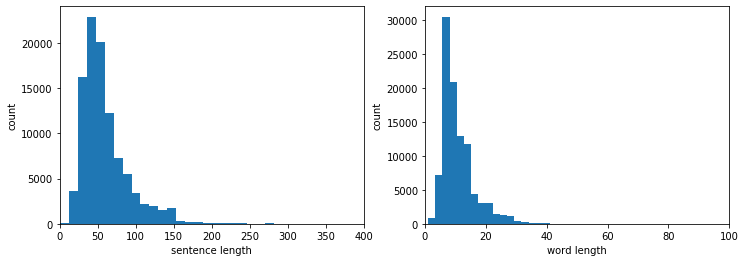

In [6]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (12, 4))

ax1.hist(q_len, bins = 100)
ax1.set_xlabel('sentence length')
ax1.set_ylabel('count')
ax1.set_xlim(0, 400)

ax2.hist(q_word, bins = 100)
ax2.set_xlabel('word length')
ax2.set_ylabel('count')
ax2.set_xlim(0, 100)
plt.show()


In [7]:
import re
def reg_norm(i):
    return re.sub('[?,.\"''"]',"",i)

In [8]:
q1_lst = [reg_norm(i).lower() for i in q1]
q2_lst = [reg_norm(i).lower() for i in q2]

In [9]:
print("before reg_norm():", q1[:1])
print("after reg_norm():", q2[:1])

before reg_norm(): ['What is the step by step guide to invest in share market in india?']
after reg_norm(): ['What is the step by step guide to invest in share market?']


In [10]:
is_dup = df.is_duplicate
is_dup[:10]

0    0
1    0
2    0
3    0
4    0
5    1
6    0
7    1
8    0
9    0
Name: is_duplicate, dtype: int64

q1, q2 -> modeling (is_dup)  predict

In [11]:
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

token = Tokenizer()
token.fit_on_texts(q1_lst + q2_lst)
vocab_size = len(token.word_index) + 1
print(vocab_size)

Using TensorFlow backend.


36077


In [12]:
q1_seq = token.texts_to_sequences(q1_lst)
q2_seq = token.texts_to_sequences(q2_lst)

In [13]:
q1_data = pad_sequences(q1_seq, maxlen = 25)
q2_data = pad_sequences(q2_seq, maxlen = 25)

In [14]:
labels = np.array(df.is_duplicate, dtype = int)
print(q1_data.shape, q2_data.shape, labels.shape)

(50000, 25) (50000, 25) (404290,)


In [15]:
from sklearn.model_selection import train_test_split

x = np.stack((q1_data, q2_data), axis = 1)
y = labels[:50000]

x.shape, y.shape

((50000, 2, 25), (50000,))

In [16]:
x_train_all, x_test, y_train_all, y_test = train_test_split(x, y, test_size = 0.1, random_state = 42)
x_train_all.shape, x_test.shape, y_train_all.shape, y_test.shape

((45000, 2, 25), (5000, 2, 25), (45000,), (5000,))

In [17]:
x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all,test_size = 0.1
                                                  , random_state = 42)
x_train.shape, x_val.shape, y_train.shape, y_val.shape

((40500, 2, 25), (4500, 2, 25), (40500,), (4500,))

In [18]:
import xgboost as xgb
train_xgb = xgb.DMatrix(x_train.sum(axis = 1), label = y_train)
eval_xgb = xgb.DMatrix(x_val.sum(axis = 1), label = y_val)
data_lst = [(train_xgb,'train'),(eval_xgb,'valid')]

In [19]:
params = {
    'objective' : 'binary:logistic',
    'eval_metric' : 'logloss',
    'eta' : 0.1,
    'max_depth': 9,
    'colsample_bytree' : 1 / x_train.shape[1]**0.5
}


model = xgb.train(params, train_xgb, num_boost_round = 1000, 
                evals = data_lst, early_stopping_rounds = 20, verbose_eval = 20)

[0]	train-logloss:0.670802	valid-logloss:0.674832
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 20 rounds.
[20]	train-logloss:0.519765	valid-logloss:0.572483
[40]	train-logloss:0.48324	valid-logloss:0.561324
[60]	train-logloss:0.468568	valid-logloss:0.559032
[80]	train-logloss:0.456399	valid-logloss:0.55843
[100]	train-logloss:0.442249	valid-logloss:0.558287
[120]	train-logloss:0.424272	valid-logloss:0.556532
[140]	train-logloss:0.411385	valid-logloss:0.556115
[160]	train-logloss:0.398435	valid-logloss:0.555874
[180]	train-logloss:0.384477	valid-logloss:0.554575
Stopping. Best iteration:
[179]	train-logloss:0.384944	valid-logloss:0.554476



In [20]:
test_xgb = xgb.DMatrix(x_test.sum(axis = 1), label = y_test)

res = model.predict(test_xgb)
res

array([0.6831435 , 0.29540205, 0.44870678, ..., 0.3017604 , 0.19856933,
       0.32698494], dtype=float32)